In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-mach/PM_test.txt
/kaggle/input/nasa-mach/PM_train.txt
/kaggle/input/nasa-mach/PM_truth.txt


In [10]:
!pip install tensorflow-addons

In [11]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
import matplotlib.pyplot as plt
from tensorflow_addons.optimizers import AdamW


plt.style.use('ggplot')
%matplotlib inline


In [12]:
# Load data
dataset_train = pd.read_csv('/kaggle/input/nasa-mach/PM_train.txt', sep=' ', header=None).drop([26, 27], axis=1)
col_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
dataset_train.columns = col_names
print('Shape of Train dataset: ', dataset_train.shape)

dataset_test = pd.read_csv('/kaggle/input/nasa-mach/PM_test.txt', sep=' ', header=None).drop([26, 27], axis=1)
dataset_test.columns = col_names
print('Shape of Test dataset: ', dataset_train.shape)

pm_truth = pd.read_csv('/kaggle/input/nasa-mach/PM_truth.txt', sep=' ', header=None).drop([1], axis=1)
pm_truth.columns = ['more']
pm_truth['id'] = pm_truth.index + 1

# Preprocessing
rul = pd.DataFrame(dataset_test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']

pm_truth['rtf'] = pm_truth['more'] + rul['max']
pm_truth.drop('more', axis=1, inplace=True)

dataset_test = dataset_test.merge(pm_truth, on=['id'], how='left')
dataset_test['ttf'] = dataset_test['rtf'] - dataset_test['cycle']
dataset_test.drop('rtf', axis=1, inplace=True)

dataset_train['ttf'] = dataset_train.groupby(['id'])['cycle'].transform(max) - dataset_train['cycle']

df_train = dataset_train.copy()
df_test = dataset_test.copy()

periods = [30, 90, 180, 365]

# Create a separate binary classification column for each period
for period in periods:
    df_train[f'label_bc_{period}'] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
    df_test[f'label_bc_{period}'] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)

df_train.head()

features_col_name = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
target_col_name = 'label_bc'

scaler = MinMaxScaler()
df_train[features_col_name] = scaler.fit_transform(df_train[features_col_name])
df_test[features_col_name] = scaler.transform(df_test[features_col_name])


Shape of Train dataset:  (20631, 26)
Shape of Test dataset:  (20631, 26)


In [13]:
# Sequence generation functions
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros = pd.DataFrame(np.zeros((seq_length - 1, id_df.shape[1])), columns=id_df.columns)
    id_df = df_zeros.append(id_df, ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array = []
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# Modify gen_label to accept the period
def gen_label(id_df, seq_length, seq_cols, label, period):
    df_zeros = pd.DataFrame(np.zeros((seq_length - 1, id_df.shape[1])), columns=id_df.columns)
    id_df['label_bc'] = id_df['ttf'].apply(lambda x: 1 if x <= period else 0)
    id_df = df_zeros.append(id_df, ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label = []
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

# Data preparation
seq_length = 50
seq_cols = features_col_name
nb_features = 10
timestamp = seq_length

'''X_train = np.concatenate(list(list(gen_sequence(df_train[df_train['id'] == id], seq_length, seq_cols)) for id in df_train['id'].unique()))
print(X_train.shape)

y_train = np.concatenate(list(list(gen_label(df_train[df_train['id'] == id], 50, seq_cols, 'label_bc', period)) for id in df_train['id'].unique()))
print(y_train.shape)

X_test = np.concatenate(list(list(gen_sequence(df_test[df_test['id'] == id], seq_length, seq_cols)) for id in df_test['id'].unique()))
print(X_test.shape)

y_test = np.concatenate(list(list(gen_label(df_test[df_test['id'] == id], 50, seq_cols, 'label_bc', period)) for id in df_test['id'].unique()))
print(y_test.shape)'''



"X_train = np.concatenate(list(list(gen_sequence(df_train[df_train['id'] == id], seq_length, seq_cols)) for id in df_train['id'].unique()))\nprint(X_train.shape)\n\ny_train = np.concatenate(list(list(gen_label(df_train[df_train['id'] == id], 50, seq_cols, 'label_bc', period)) for id in df_train['id'].unique()))\nprint(y_train.shape)\n\nX_test = np.concatenate(list(list(gen_sequence(df_test[df_test['id'] == id], seq_length, seq_cols)) for id in df_test['id'].unique()))\nprint(X_test.shape)\n\ny_test = np.concatenate(list(list(gen_label(df_test[df_test['id'] == id], 50, seq_cols, 'label_bc', period)) for id in df_test['id'].unique()))\nprint(y_test.shape)"

In [14]:
from tabulate import tabulate
# Loop through the periods, train and evaluate the models
results = []
for period in periods:
    # Update label_bc column for training and test datasets
    df_train['label_bc'] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
    df_test['label_bc'] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)
    
    # Generate sequences and labels for current period
    X_train = np.concatenate(list(list(gen_sequence(df_train[df_train['id'] == id], seq_length, seq_cols)) for id in df_train['id'].unique()))
    y_train = np.concatenate(list(list(gen_label(df_train[df_train['id'] == id], 50, seq_cols, 'label_bc', period)) for id in df_train['id'].unique()))
    X_test = np.concatenate(list(list(gen_sequence(df_test[df_test['id'] == id], seq_length, seq_cols)) for id in df_test['id'].unique()))
    y_test = np.concatenate(list(list(gen_label(df_test[df_test['id'] == id], 50, seq_cols, 'label_bc', period)) for id in df_test['id'].unique()))

    # Create a new model for the current period
    from keras.layers import Dense, LSTM, Dropout, Bidirectional, BatchNormalization, Reshape

# Create a new model for the current period
    model = Sequential()

    model.add(Bidirectional(LSTM(units=128, input_shape=(timestamp, nb_features), return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Reshape((-1, 2*64)))
    model.add(Bidirectional(LSTM(units=32, return_sequences=False)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=500, validation_split=0.05, verbose=1,
              callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

    # Evaluate the model
    scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
    print(f"Accurracy for {period} days period: {scores[1]}")

    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    print(f"Accuracy of model on test data for {period} days period: {accuracy_score(y_test, y_pred)}")
    print(f"Confusion Matrix for {period} days period: \n{confusion_matrix(y_test, y_pred)}")

    # Save the model for the current period
    model.save(f'model_{period}_days.h5')
    results.append([period, scores[0], scores[1], accuracy_score])



Epoch 1/10
40/40 [==============================] - 16s 111ms/step - loss: 0.4720 - accuracy: 0.7668 - val_loss: 0.6001 - val_accuracy: 0.8491
Epoch 2/10
103/103 [==============================] - 1s 12ms/step - loss: 0.5409 - accuracy: 0.8490
Accurracy for 30 days period: 0.8490087985992432
407/407 [==============================] - 5s 8ms/step
Accuracy of model on test data for 30 days period: 0.9744536780547861
Confusion Matrix for 30 days period: 
[[12664     0]
 [  332     0]]
Epoch 1/10
40/40 [==============================] - 17s 112ms/step - loss: 0.5296 - accuracy: 0.7164 - val_loss: 0.6687 - val_accuracy: 0.7167
Epoch 2/10
103/103 [==============================] - 1s 12ms/step - loss: 0.6428 - accuracy: 0.7789
Accurracy for 90 days period: 0.7788709998130798
407/407 [==============================] - 5s 8ms/step
Accuracy of model on test data for 90 days period: 0.7261465066174208
Confusion Matrix for 90 days period: 
[[7237 3182]
 [ 377 2200]]
Epoch 1/10
40/40 [============

In [15]:
# Print the table
headers = ['Period', 'Final Loss', 'Final Accuracy', 'Test Accuracy']
print(tabulate(results, headers=headers, floatfmt=".4f"))

  Period    Final Loss    Final Accuracy  Test Accuracy
--------  ------------  ----------------  -------------------------------------------
      30        0.5409            0.8490  <function accuracy_score at 0x791573adf010>
      90        0.6428            0.7789  <function accuracy_score at 0x791573adf010>
     180        0.5514            0.8491  <function accuracy_score at 0x791573adf010>
     365        0.3597            1.0000  <function accuracy_score at 0x791573adf010>


In [16]:
from keras.models import load_model

def prob_failure(machine_id, period):
    machine_df = df_test[df_test.id == machine_id]

    # Adjust the label generation based on the period
    machine_df['label_bc'] = machine_df['ttf'].apply(lambda x: 1 if x <= period else 0)
    machine_df['ttf'] = machine_df['ttf'].apply(lambda x: x if x <= period else period)

    machine_test = gen_sequence(machine_df, seq_length, seq_cols)
    
    # Load the saved model for the current period
    model = load_model(f'model_{period}_days.h5')
    
    m_pred = model.predict(machine_test)
    failure_prob = list(m_pred[-1] * 100)[0]
    return failure_prob


periods = [30, 90, 180, 365]
machine_ids = df_test['id'].unique()

# Create an empty DataFrame
results_df = pd.DataFrame(columns=['Machine ID'] + [f"{period} days" for period in periods])

for machine_id in machine_ids:
    failure_probs = [prob_failure(machine_id, period) for period in periods]
    results_df = results_df.append(pd.Series([machine_id] + failure_probs, index=results_df.columns), ignore_index=True)

results_df.set_index('Machine ID', inplace=True)

machine_id = 16
period = 30
print('Probability that machine will fail within 30 days: ', prob_failure(machine_id, period))



4/4 [==============================] - 3s 9ms/step
Probability that machine will fail within 30 days:  35.724606


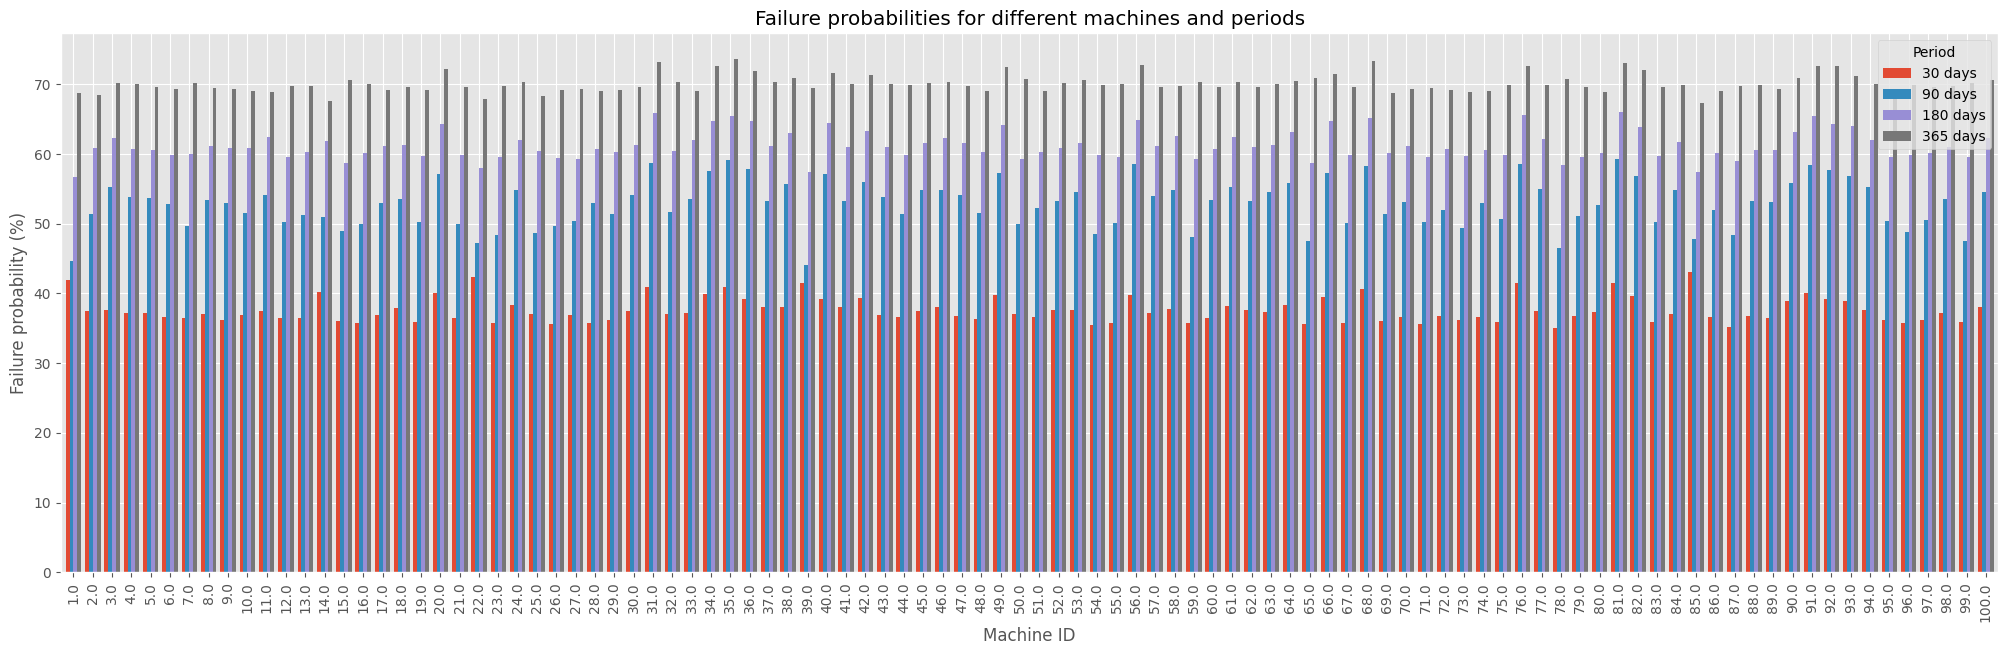

In [17]:
import matplotlib.pyplot as plt

# Set plot size and title
plt.figure(figsize=(25, 7))
plt.title("Failure probabilities for different machines and periods")

# Create a bar plot
results_df.plot(kind='bar', width=0.8, ax=plt.gca())

# Set labels and legend
plt.xlabel("Machine ID")
plt.ylabel("Failure probability (%)")
plt.legend(title="Period", loc='upper right')

# Show the plot
plt.show()


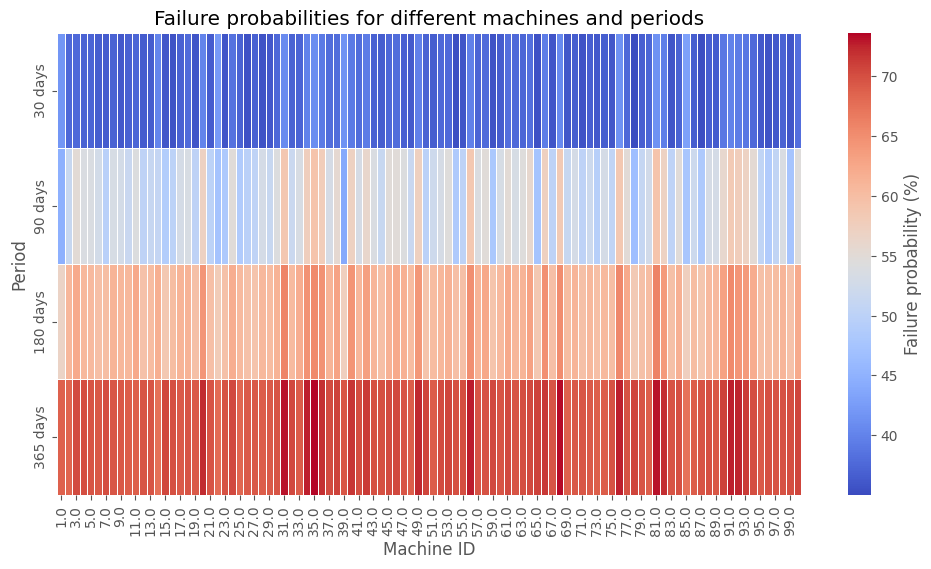

In [23]:
import seaborn as sns

# Pivot the results DataFrame to create a matrix of failure probabilities
pivot_df = results_df.transpose()

# Set plot size and title
plt.figure(figsize=(12, 6))
plt.title("Failure probabilities for different machines and periods")

# Create a heatmap
sns.heatmap(pivot_df, cmap='coolwarm', annot=False, fmt=".1f", linewidths=.5, cbar_kws={'label': 'Failure probability (%)'})

# Set labels and legend
plt.ylabel("Period")
plt.xlabel("Machine ID")

# Show the plot
plt.show()


Epoch 1/20
35/35 [==============================] - 2s 55ms/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 2/20
35/35 [==============================] - 2s 55ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000


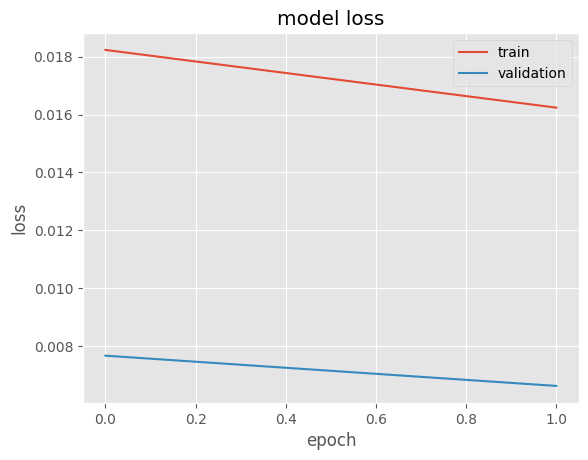

In [28]:
history = model.fit(X_train, y_train, epochs=20, batch_size=300, validation_split=0.5, verbose=1, 
                    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


407/407 [==============================] - 4s 9ms/step


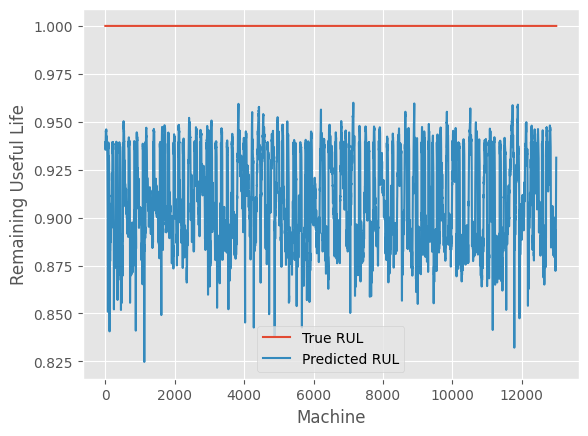

In [25]:
y_pred = model.predict(X_test)
plt.plot(y_test, label='True RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.xlabel('Machine')
plt.ylabel('Remaining Useful Life')
plt.legend()
plt.show()


In [21]:
results_df

,30 days,90 days,180 days,365 days
Machine ID,,,,
1.0,41.863773,44.697155,56.741993,68.723557
2.0,37.469276,51.453365,60.922569,68.456764
3.0,37.677639,55.218487,62.281342,70.171089
4.0,37.126106,53.861851,60.713131,70.028877
5.0,37.153107,53.744370,60.599220,69.637848
...,...,...,...,...
96.0,35.753887,48.738701,59.920341,69.902351
97.0,36.195625,50.572193,60.070450,69.587212
98.0,37.116756,53.597649,61.052383,69.815407


This information can be used by maintenance teams to prioritize which machines need attention first, and to plan maintenance schedules accordingly. By monitoring machines and predicting their probability of failure, maintenance can be scheduled before the machine fails, which can reduce downtime and maintenance costs.

In terms of spare parts and storage, predicting machine failure can help companies plan their inventory and supply chain management. By knowing which machines are likely to fail, companies can stock up on the necessary spare parts and reduce the risk of delays due to out-of-stock items. Additionally, knowing the probability of failure can help companies plan for the necessary space and storage requirements for the spare parts inventory.